In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import PIL
from tensorflow.keras import layers
import time
from IPython import display

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    except RuntimeError as e:
        print(e)

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.


In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

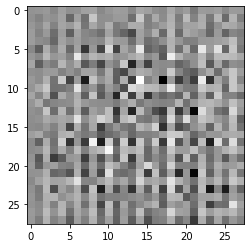

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49984175]], shape=(1, 1), dtype=float32)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
EPOCH = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss, gen_loss

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        d_loss, g_loss = 0, 0
        for image_batch in dataset:
            loss = train_step(image_batch)
            d_loss += loss[0]
            g_loss += loss[1]
            
        display.clear_output(wait=True)
        generated_images(generator, epoch+1, seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('D loss : ',d_loss.numpy()/BATCH_SIZE, 'G loss :',g_loss.numpy()/BATCH_SIZE)

def generated_images(generator, epoch, seed):
    images = generator(seed, training = False)
    fig = plt.figure(figsize=(4,4))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

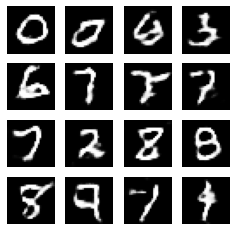

Time for epoch 50 is 7.147075653076172 sec
D loss :  0.40566742420196533 G loss : 0.32301509380340576
CPU times: user 1min 13s, sys: 3.21 s, total: 1min 16s
Wall time: 6min


In [22]:
%%time
train(train_dataset, EPOCH)